In [1]:
import os
import sys

sys.path.append('/home/jovyan/work/obstacle-detection')
sys.path.append('/home/jovyan/work/')
import numpy as np
import pandas as pd

import pcl
import pcl.pcl_visualization
import pythreejs
import pyntcloud
import matplotlib.pyplot as plt
from importlib import reload  

from pipeline import pcl_pipeline

In [2]:
PATH_TO_DATASET = '/home/jovyan/work/dataset_sampling/rangenet_sampling/dataset/sequences/00/'

In [3]:
scan = np.fromfile(PATH_TO_DATASET + 'velodyne/000055.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile(PATH_TO_DATASET + 'labels/000055.label', dtype=np.uint32)
label = label.reshape((-1))

cloud_XYZ = pcl.PointCloud()
cloud_XYZ.from_array(scan[:,:3])

In [4]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [13]:
def roi_filter(pcloud, verbose=True, **params):
    if verbose:
        print('Input pcloud size: {}'.format(len(pcloud)))
    pcloud['camera'] = ((pcloud['x'] > params['min_x']) & (pcloud['x'] < params['max_x']) &
                       (pcloud['y'] >  params['min_y']) & (pcloud['y'] < params['max_y']) &
                       (pcloud['z'] >  params['min_z']) & (pcloud['z'] <  params['max_z']))
    pcloud = pcloud[pcloud['camera'] == True]
    pcloud = pcloud.drop(['camera'], axis=1)
    if verbose:
        print('Output ROI pcloud size: {}'.format(len(pcloud)))
    return pcloud

# pcloud = roi_filter(pcloud, min_x=-6, max_x=50, 
#                   min_y=-20, max_y=25, 
#                   min_z=-2, max_z=2)

In [16]:
pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                      columns=['x', 'y', 'z', 'seg_id'])
pcloud.seg_id = pcloud.seg_id.astype('uint32')
pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
pcloud_to_pcl = pcloud.drop(['seg_id'], axis=1)
print(pcloud_to_pcl.shape)
pcloud_pcl = pcl.PointCloud()
pcloud_pcl.from_array(pcloud_to_pcl.to_numpy(dtype=np.float32))

# сколько в метрах?, перебрать параметры по X
pcloud_pcl_roi = pcl_pipeline.roi_filter(pcloud_pcl, [-30, 30], [-6, 8], [-3, 3])

pcloud_pcl_roi_array = np.array(pcloud_pcl_roi, dtype=np.float32)
print(pcloud_pcl_roi_array.shape)

pcloud_pcl_fil = pcloud_pcl_roi.make_statistical_outlier_filter()
pcloud_pcl_fil.set_mean_k(50)
pcloud_pcl_fil.set_std_dev_mul_thresh(1.0)
pcloud_array = np.array(pcloud_pcl_fil.filter(), dtype=np.float32)
print(pcloud_array.shape)

#temp_cloud = pcloud[pcloud.seg_id == 10]
#temp_cloud = temp_cloud.drop(['seg_id'], axis=1)

(16053, 3)
(15408, 3)
(14011, 3)


In [30]:
def plane_segmentation(cloud, dist_thold, max_iter):
    """
    Input parameters:
        cloud: Input cloud
        dist_thold: distance threshold
        max_iter: maximal number of iteration
    Output:
        indices: list of indices of the PCL points that belongs to the plane
        coefficient: the coefficients of the plane-fitting (e.g., [a, b, c, d] for ax + by +cz + d =0)
    """
    seg = cloud.make_segmenter_normals(ksearch=50)# For simplicity,hard coded
    seg.set_optimize_coefficients(True)
    seg.set_model_type(pcl.SACMODEL_NORMAL_PLANE)
    seg.set_method_type(pcl.SAC_RANSAC)
    seg.set_distance_threshold(dist_thold)
    seg.set_max_iterations(max_iter)
    indices, coefficients = seg.segment()
    return indices, coefficients

In [33]:
from datetime import datetime
import time
from importlib import reload  
from pipeline import common

pcl_pipeline = reload(pcl_pipeline)

def pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):

    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])

    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pcloud.drop(['seg_id'], axis=1)
    #pcloud = pcloud.drop(['camera'], axis=1)
    pcloud_pcl = pcl.PointCloud()
    pcloud_pcl.from_array(pcloud.to_numpy(dtype=np.float32))
    obstacle_time = datetime.now() - start_time
    
    # get voxel grid
    start_time = datetime.now()
    #pcloud_pcl = pcl.PointCloud()
    #pcloud_pcl.from_array(pcloud.to_numpy(dtype=np.float32))
    voxelgrid_id = pcl_pipeline.voxel_filter(pcloud_pcl, [params['x_voxels'],
                                                          params['y_voxels'],
                                                          params['z_voxels']])
    #voxelgrid_id = pcloud_pcl  
    voxel_time = datetime.now() - start_time

    # ROI filter
    start_time = datetime.now()
    pcloud_roi = pcl_pipeline.roi_filter(voxelgrid_id, [params['roi_x_min'], params['roi_x_max']], 
                                    [params['roi_y_min'], params['roi_y_max']], 
                                    [params['roi_z_min'], params['roi_z_max']],)
    #pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
    #                                    min_y=params['roi_y_min'], max_y=params['roi_y_max'],
    #                                    min_z=params['roi_z_min'], max_z=params['roi_z_max'], verbose=False)
    roi_time = datetime.now() - start_time
    
    indices, coefficients = plane_segmentation(pcloud_roi, 0.3, 100)
    cloud_obsts = pcloud_roi.extract(indices, negative = True)

    # get cluster
    start_time = datetime.now()

    cluster_indices = pcl_pipeline.clustering(cloud_obsts, params['tol_distance'], params['min_cluster_size'], 150000)        
    clustering_time = datetime.now() - start_time
    
    print(np.array(pcloud_pcl, dtype=np.float32).shape, len(cluster_indices))
    
    # get bboxes
    start_time = datetime.now()
    cloud_cluster_list, box_coord_list = pcl_pipeline.get_cluster_box_list(
                                                cluster_indices, cloud_obsts, 
                                                radius_search=params['radius_search'], 
                                                min_neighbors_in_radius=params['min_neighbors_in_radius'])

    bbox_time = datetime.now() - start_time

    n = 1000
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.0f} ms'.format(roi_time.microseconds / n))
        print('\n - Filtering obstacles: {:.0f} ms'.format(obstacle_time.microseconds / n))
        print('\n - Voxel grid: {:.0f} ms'.format(voxel_time.microseconds / n))
        print('\n - Clustering: {:.0f} ms'.format(clustering_time.microseconds / n))
        print('\n - Min-max cluster points: {:.0f} ms \n'.format(bbox_time.microseconds / n))
        
    if exec_time:
        return box_coord_list, voxelgrid_id, {'roi_time': roi_time.microseconds / n,
                                        'filter_obstacle_time': obstacle_time.microseconds / n,
                                        'voxel_grid_time': voxel_time.microseconds / n,
                                        'clustering_time': clustering_time.microseconds / n,
                                        'outlier_filter_bbox_time': bbox_time.microseconds / n}
    else:
        return box_coord_list, voxelgrid_id

In [34]:
params = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : -30,   'roi_x_max'              : 30,
          'roi_y_min'    : -6, 'roi_y_max'                : 8,
          'roi_z_min'    : -3,  'roi_z_max'                : 3, 
          'tol_distance' : 0.7, 'min_cluster_size'         : 30,
          'radius_search': 0.8,   'min_neighbors_in_radius': 2}
%time box_coord_list, pcloud_pcl, time = pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=True, exec_time=True, **params)

(10679, 3) 8
Execution time:

 - ROI filtering: 1 ms

 - Filtering obstacles: 446 ms

 - Voxel grid: 5 ms

 - Clustering: 27 ms

 - Min-max cluster points: 9 ms 

CPU times: user 493 ms, sys: 71 ms, total: 564 ms
Wall time: 572 ms


In [24]:
box_coord_list, time

([array([[-43.13823318,  45.83708191,  45.83708191, -43.13823318,
          -43.13823318,  45.83708191,  45.83708191, -43.13823318],
         [ -4.20545006,  -4.20545006,   8.9893446 ,   8.9893446 ,
           -4.20545006,  -4.20545006,   8.9893446 ,   8.9893446 ],
         [ -2.04606462,  -2.04606462,  -2.04606462,  -2.04606462,
            0.26768413,   0.26768413,   0.26768413,   0.26768413]]),
  array([[-11.17521   ,  44.60187531,  44.60187531, -11.17521   ,
          -11.17521   ,  44.60187531,  44.60187531, -11.17521   ],
         [ -4.20443678,  -4.20443678,  10.71786785,  10.71786785,
           -4.20443678,  -4.20443678,  10.71786785,  10.71786785],
         [ -1.2731303 ,  -1.2731303 ,  -1.2731303 ,  -1.2731303 ,
            0.26774919,   0.26774919,   0.26774919,   0.26774919]]),
  array([[-43.72450256,  47.29917908,  47.29917908, -43.72450256,
          -43.72450256,  47.29917908,  47.29917908, -43.72450256],
         [ -4.46861839,  -4.46861839,   8.84343815,   8.84343815,

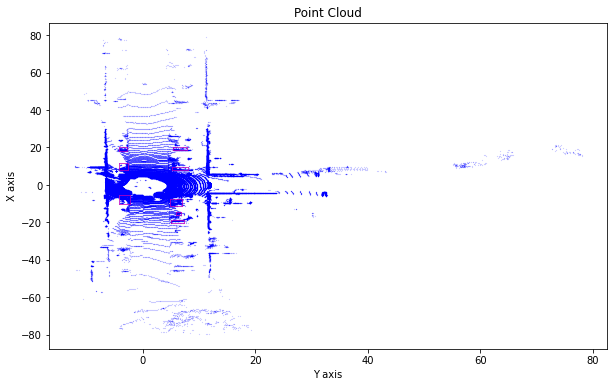

In [35]:
from scripts import draw

%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [132]:
np.array(pcloud_pcl, dtype=np.float32).size

2559

In [22]:
import pandas as pd
scan1 = scan[:,:3]
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(np.array(pcloud_pcl, dtype=np.float32), columns=['x','y','z']))
test_cloud.plot(backend='pythreejs', use_as_color='seg_id')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(14.612958908081055, 12.31294846534729, -0.52…